## Heatmap

In [172]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [173]:
bs = 512

In [174]:
min_pixels = 50

In [175]:
path = pathlib.PosixPath(f"/storage_1/dataset_classification_min_{min_pixels}_pixels/")
path

PosixPath('/storage_1/dataset_classification_min_50_pixels')

In [176]:
tfms = get_transforms(flip_vert=True, do_flip=True, p_affine=0., p_lighting=0., max_zoom=1.)

In [177]:
src = ImageList.from_folder(path).split_by_folder()

In [178]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [179]:
data = get_data(224, bs, 'zeros')

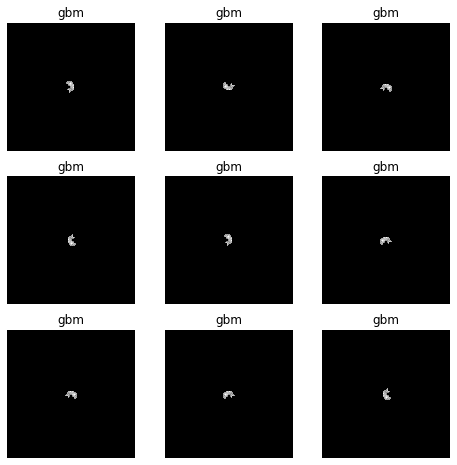

In [180]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [181]:
data = get_data(224,bs)

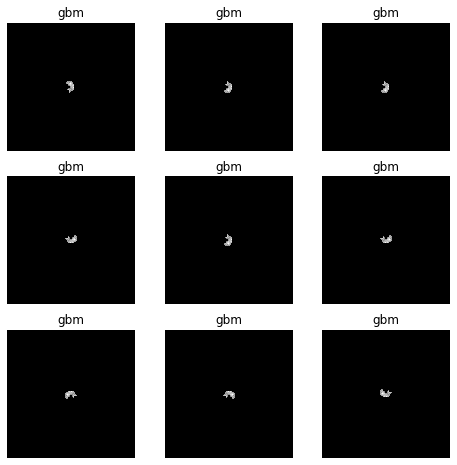

In [182]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [183]:
# best model so far, with switched off transforms
learn = cnn_learner(data, models.resnet101, metrics=error_rate).load('resnet101-stage-1-ep8')

Category gbm

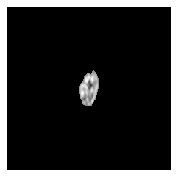

In [184]:
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [185]:
len(data.valid_ds)

18400

Category met

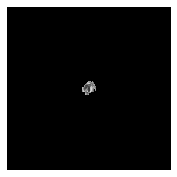

In [186]:
idx_last = -1
x_last,y_last = data.valid_ds[idx_last]
x_last.show()
data.valid_ds.y[idx_last]

## Heatmap

In [187]:
m = learn.model.eval();

In [188]:
xb,_ = data.one_item(x_last)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [189]:
from fastai.callbacks.hooks import *

In [190]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [191]:
hook_a,hook_g = hooked_backward()

In [192]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 7, 7])

In [193]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [194]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

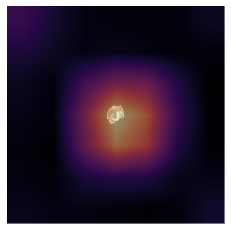

In [195]:
show_heatmap(avg_acts)